In [31]:
%load_ext autoreload
%autoreload 2
import math
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from helpers import *

data_folder = 'DATA/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# load data
movie_data = pd.read_csv(data_folder + 'movie_data.csv')
character_data = pd.read_csv(data_folder + 'characters_data.csv')
main_characters = pd.read_csv(data_folder + "main_characters_20_per_year")

C:\Users\lucil\AppData\Local\Temp\ipykernel_14564\3248464955.py:3: DtypeWarning: Columns (2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  character_data = pd.read_csv(data_folder + 'characters_data.csv')


# Clustering
The idea is to create a dataframe for each movie with the characteristics extracted from the data that could make them more stereotypical, namely:
- proportion of women in the movie
- female/male ratio of main character
- difference between mean age of men and of women
- persona

The clustering algorithm should thus group movies together that have similar level of gender stereotypes. We can then analyse the movies in these clusters to see if movie some genres, decades or popularity scores are more present in stereotypical movies. We can also analyse how the number of stereotypical movies evolve.

In [35]:
# remove character with unknown genders
character_data = character_data.dropna(subset='actor_gender')

### Proportion of female actress

In [36]:
# compute proportion of female actress per movie
characters_per_movie = character_data.groupby('IMDB_ID')
proportion_female = characters_per_movie['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))

In [37]:
# create a dataframe on which we will perform clustering
stereotype_df = pd.DataFrame({'IMDB_ID': proportion_female.index, 'proportion_female': proportion_female.values})

### Proportion of female main character
To re-do once we have this for more movies

In [38]:
main_characters = main_characters.drop(columns='Unnamed: 0')

In [39]:
# compute the proportion of female main character for each movie
main_characters_ratio = main_characters['main character genders'].apply(calculate_gender_ratio)
main_characters['proportion_female_main_char'] = main_characters_ratio
# remove movies with unknown main characters genders
main_characters = main_characters.dropna(subset='proportion_female_main_char')
main_characters

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,genre,plot_summary,IMDB_ID,main characters,main character genders,proportion_female_main_char
1,13707776.0,/m/03cfrk4,fatty joins the force,1913,NaN,12.0,"['Silent film', 'Indie', 'Black-and-white', 'S...",Fatty is an obese and timid man who rescues a ...,NaN,['fatty'],['M'],0.0
3,19200075.0,/m/04lg64k,dimples,1916,NaN,NaN,"['Silent film', 'Black-and-white']","Dimples is a young girl, whose father dies. Sh...",NaN,"['dimples', 'robert']","['F', 'M']",0.5
4,74391.0,/m/0jvw0,the immigrant,1917,NaN,24.0,"['Silent film', 'Black-and-white', 'Short Film...",The film begins aboard a steamer crossing the ...,NaN,['tramp'],['M'],0.0
5,15296595.0,/m/03hpf68,great expectations,1917,NaN,50.0,"['Silent film', 'Drama', 'Indie', 'Black-and-w...","A young boy, Pip, runs into an escaped convict...",NaN,"['pip', 'magwitch']",['M'],0.0
6,20498584.0,/m/04zy9rx,the secret of the storm country,1917,NaN,72.0,"['Silent film', 'Drama', 'Black-and-white']",Tess Skinner is the daughter of an indigent sq...,NaN,"['frederick graves', 'tess skinner', 'madelene...",['F'],1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1576,NaN,NaN,division,2022,NaN,NaN,['Drama'],"[""When a Z-list actress connects with a fan wh...",tt14069588,"['jaime', 'mason', 'zach']",['F'],1.0
1579,NaN,NaN,out of the blue,2022,NaN,NaN,"['Crime', 'Drama', 'Mystery', 'Romance', 'Thri...","['Connor, a man whose dull life is transformed...",tt15333788,"['connor', 'marilyn']","['M', 'F']",0.5
1580,NaN,NaN,captivity,2022,NaN,NaN,['Thriller'],['Ashley is a college student who gets abducte...,tt19177942,"['ashley', 'samuel']","['F', 'M']",0.5
1582,NaN,NaN,dr. saville's horror show,2022,NaN,NaN,['Horror'],['As the evil Dr. Saville tortures his latest ...,tt10151386,['saville'],['M'],0.0


In [40]:
# merge main characters with movie data to retrieve IMDB IDs -> can be removed once analysis is done on the newest dataset
main_characters = main_characters.dropna(subset='wikipedia_ID')
main_characters = pd.merge(main_characters[['wikipedia_ID', 'proportion_female_main_char']], movie_data[['IMDB_ID', 'wikipedia_ID']], on='wikipedia_ID', how='left')
main_characters

,wikipedia_ID,proportion_female_main_char,IMDB_ID
0,13707776.0,0.000000,tt0002851
1,19200075.0,0.500000,tt0006594
2,74391.0,0.000000,tt0008133
3,15296595.0,0.000000,tt0008029
4,20498584.0,1.000000,tt0008554
...,...,...,...
1202,35176390.0,0.500000,tt1498878
1203,33096336.0,0.333333,tt1588334
1204,29423778.0,0.666667,tt1497874
1205,31520425.0,0.500000,tt1730687


In [41]:
# merge with clustering dataframe and keep only movies with known main character proportions
stereotype_df = pd.merge(stereotype_df, main_characters[['IMDB_ID', 'proportion_female_main_char']], on='IMDB_ID', how='left')
stereotype_df = stereotype_df.dropna(subset='proportion_female_main_char')

### Age difference
Here we compute the difference of the mean age between men and women. This is added to the clustering data set since movies with much older men than women could be considered as more stereotypical.

In [42]:
mean_ages = compute_difference_mean_ages(character_data)
stereotype_df = pd.merge(stereotype_df, mean_ages[['IMDB_ID', 'difference_mean_ages']], on='IMDB_ID', how='left')
stereotype_df = stereotype_df.dropna(subset='difference_mean_ages')
stereotype_df

,IMDB_ID,proportion_female,proportion_female_main_char,difference_mean_ages
0,tt0002851,0.222222,0.000000,-0.166667
1,tt0006594,0.454545,0.500000,-19.666667
2,tt0008029,0.250000,0.000000,-21.000000
3,tt0008133,0.176471,0.000000,-11.333333
4,tt0008554,0.500000,1.000000,0.666667
...,...,...,...,...
1175,tt1588334,0.294118,0.333333,5.272727
1176,tt1589487,0.562500,1.000000,-3.690476
1177,tt1695994,0.526316,0.000000,7.166667
1178,tt1730687,0.416667,0.500000,-5.400000


### Character personas

### Clustering with K-means
Before doing the clustering, we need to pre-process the data. Proportions of female and of female main character are already normalised. We thus only need to normalise the age difference. We also identify the optimal number of cluster using the elbow of the sum of square error method.

In [43]:
clustering_df = stereotype_df.drop(columns='IMDB_ID')
clustering_df['difference_mean_ages'] = MinMaxScaler().fit_transform(clustering_df['difference_mean_ages'].values.reshape(-1, 1))

C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak

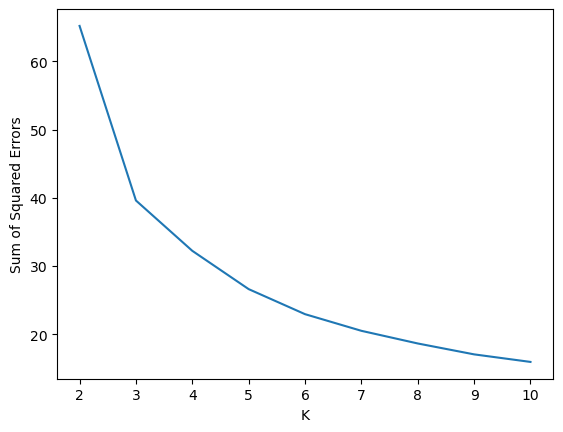

In [44]:
plot_sse(clustering_df)

We see on the plot above that the elbow of the curve is located at n=3. We will thus perform clustering with k=3.

In [45]:
#silhouettes = []

# Try multiple k
#for k in range(2, 11):
    # Cluster the data and assigne the labels
#    labels = KMeans(n_clusters=k, random_state=10).fit_predict(data)
    # Get the Silhouette score
#    score = silhouette_score(data, labels)
#    silhouettes.append({"k": k, "score": score})

# Convert to dataframe
#silhouettes = pd.DataFrame(silhouettes)

# Plot the data
#plt.plot(silhouettes.k, silhouettes.score)
#plt.xlabel("K")
#plt.ylabel("Silhouette score")

In [46]:
# run k-means
kmean = KMeans(n_clusters=3, random_state=0).fit(clustering_df)

C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


### Visualising the clusters

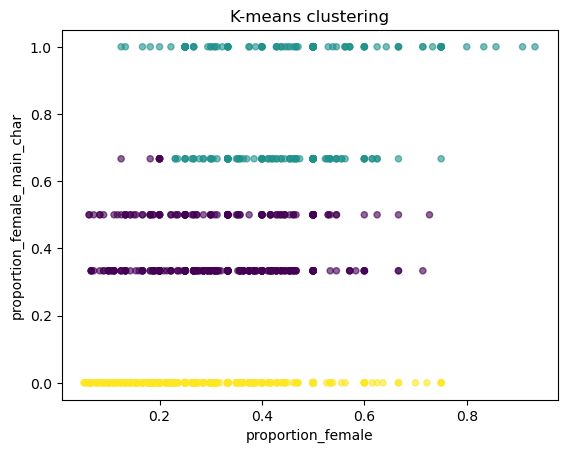

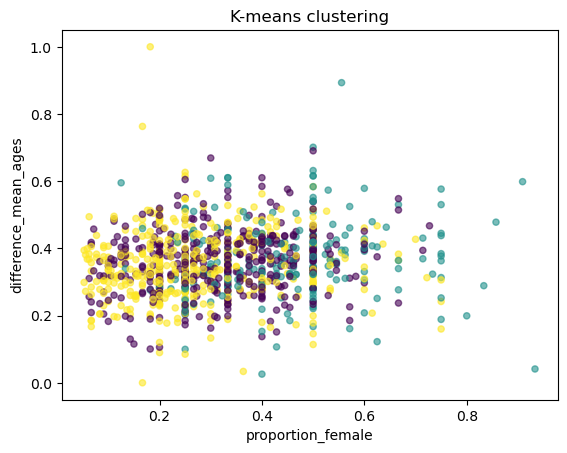

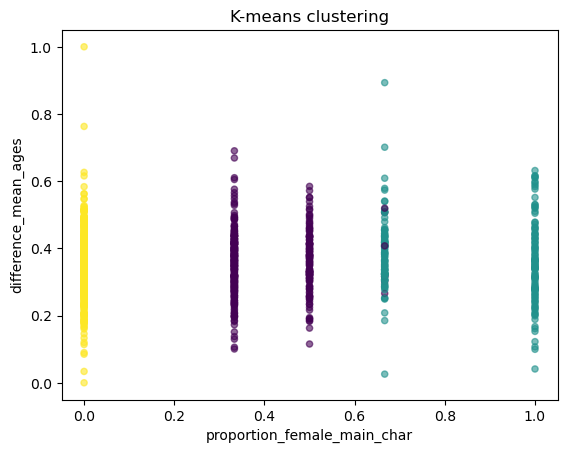

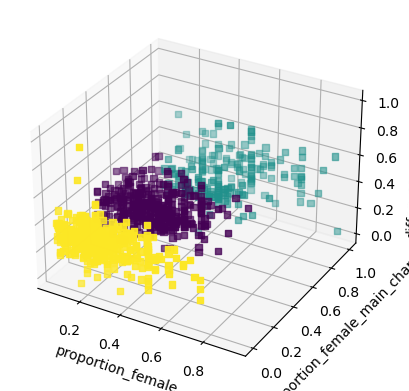

In [47]:
plot_kmeans_2d(clustering_df, kmean.labels_, ['proportion_female', 'proportion_female_main_char'])
plot_kmeans_2d(clustering_df, kmean.labels_, ['proportion_female', 'difference_mean_ages'])
plot_kmeans_2d(clustering_df, kmean.labels_, ['proportion_female_main_char', 'difference_mean_ages'])
plot_kmeans_3d(clustering_df, kmean.labels_, ['proportion_female', 'proportion_female_main_char', 'difference_mean_ages'])

### Analysing the clusters

In [48]:
# add k-means label to the dataset that also contains IMDB IDs
#clustering_df['cluster_index'] = kmean.labels_
stereotype_df['cluster_index'] = kmean.labels_
# add IMDB_ID to the clustering dataframe
#data = pd.concat([clustering_df, stereotype_df['IMDB_ID']], axis=1)

In [49]:
#pd.merge(data, stereotype_df[['IMDB_ID', 'difference_mean_ages']], on='IMDB_ID', how='left').drop(columns='IMDB_ID').groupby('cluster_index').describe()

In [50]:
stereotype_df.drop(columns='IMDB_ID').groupby('cluster_index').mean()

,proportion_female,proportion_female_main_char,difference_mean_ages
cluster_index,,,
0,0.320458,0.393745,-7.025197
1,0.451575,0.843505,-5.881839
2,0.276084,0.000000,-8.028496


We see that cluster 1 seems to be the less stereotypical with higher proportion of women in the cast and as main character. Cluster 2 seems to be the most stereotypical. In this notebook, we are mostly interested in analysing movies in the extremes. We will thus discard cluster 0.
TODO: develop why stereotypical/non-stereotypical cluster is so (using proportions, ages numbers blablabla)
For the rest of the analysis, we will focus on these two clusters.

In [51]:
# select most and least stereotypical movies according to the clustering
not_stereotypical_ids = stereotype_df[stereotype_df['cluster_index'] == 1]['IMDB_ID']
not_stereotypical_movies = movie_data[movie_data['IMDB_ID'].isin(not_stereotypical_ids)]
stereotypical_ids = stereotype_df[stereotype_df['cluster_index'] == 2]['IMDB_ID']
stereotypical_movies = movie_data[movie_data['IMDB_ID'].isin(stereotypical_ids)]

In [52]:
not_stereotypical_movies.describe()[['release_date', 'popularity']]

,release_date,popularity
count,213.000000,67.000000
mean,1971.802817,0.201143
std,26.619410,0.266832
min,1917.000000,0.000091
25%,1948.000000,0.031452
50%,1978.000000,0.136170
75%,1997.000000,0.256710
max,2010.000000,1.786852


In [53]:
stereotypical_movies.describe()[['release_date', 'popularity']]

,release_date,popularity
count,407.000000,186.000000
mean,1973.845209,0.231576
std,24.515866,0.297486
min,1913.000000,0.000035
25%,1952.500000,0.045017
50%,1978.000000,0.127949
75%,1995.000000,0.268066
max,2013.000000,1.817129


# TODO: ANALYSE

Now, let's have a look at the genre of movies present in both categories of movies

In [54]:
stereotypical_movies['genre'] = stereotypical_movies['genre'].apply(ast.literal_eval)
not_stereotypical_movies['genre'] = not_stereotypical_movies['genre'].apply(ast.literal_eval)

C:\Users\lucil\AppData\Local\Temp\ipykernel_14564\3983253857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stereotypical_movies['genre'] = stereotypical_movies['genre'].apply(ast.literal_eval)
C:\Users\lucil\AppData\Local\Temp\ipykernel_14564\3983253857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_stereotypical_movies['genre'] = not_stereotypical_movies['genre'].apply(ast.literal_eval)


In [55]:
not_stereotypical_genre_counts = not_stereotypical_movies['genre'].explode().value_counts()

In [56]:
stereotypical_genre_counts = stereotypical_movies['genre'].explode().value_counts()

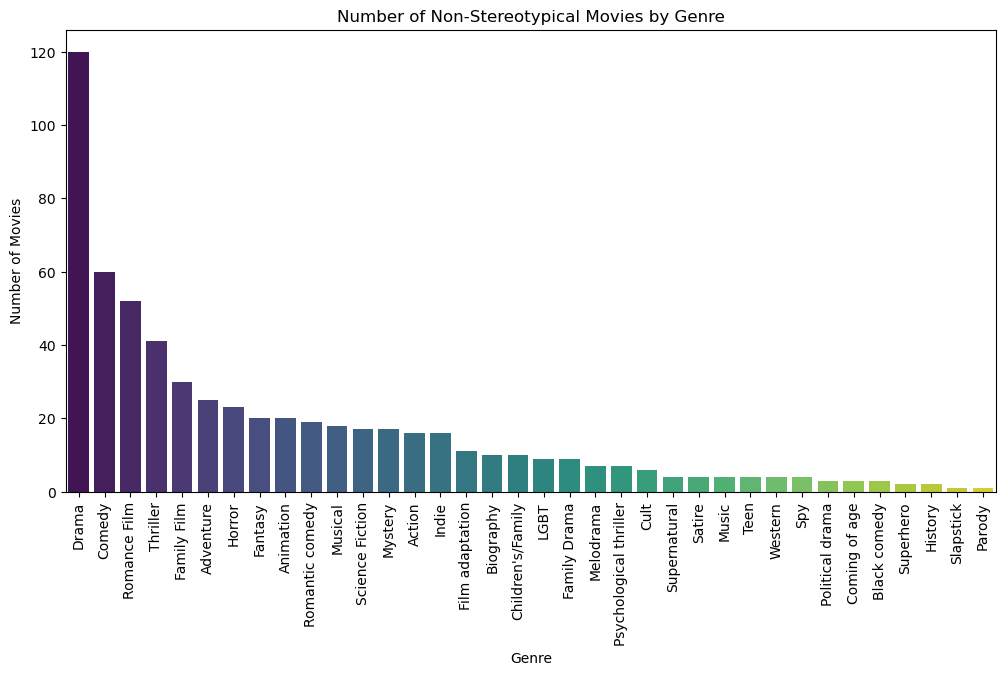

In [57]:
plt.figure(figsize=(12, 6))
sns.barplot(x=not_stereotypical_genre_counts.index, y=not_stereotypical_genre_counts.values, palette='viridis')
plt.title('Number of Non-Stereotypical Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

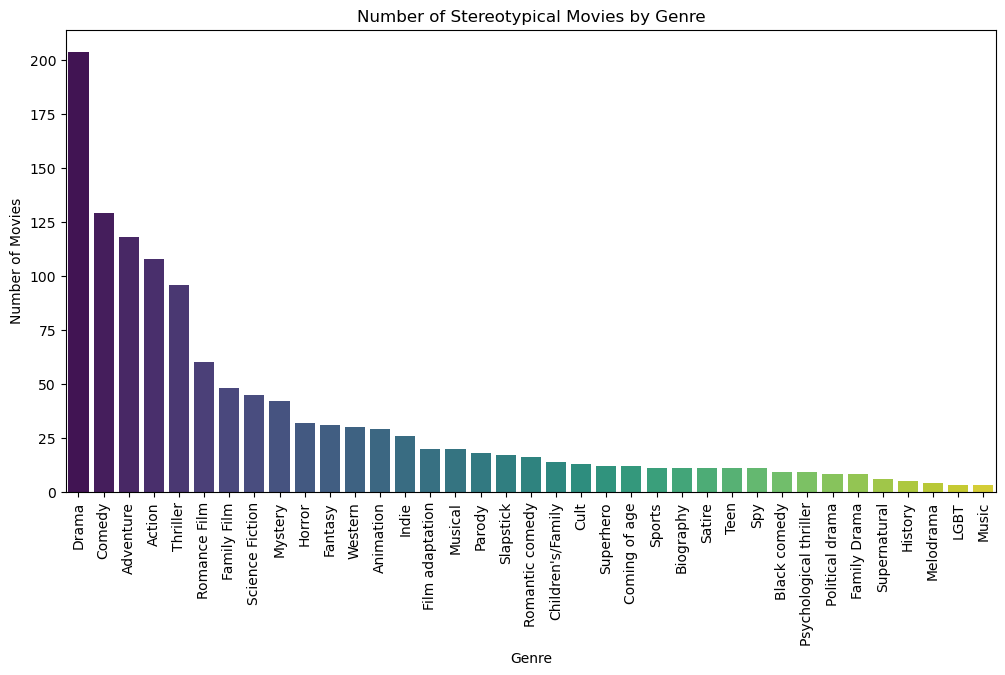

In [58]:
plt.figure(figsize=(12, 6))
sns.barplot(x=stereotypical_genre_counts.index, y=stereotypical_genre_counts.values, palette='viridis')
plt.title('Number of Stereotypical Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

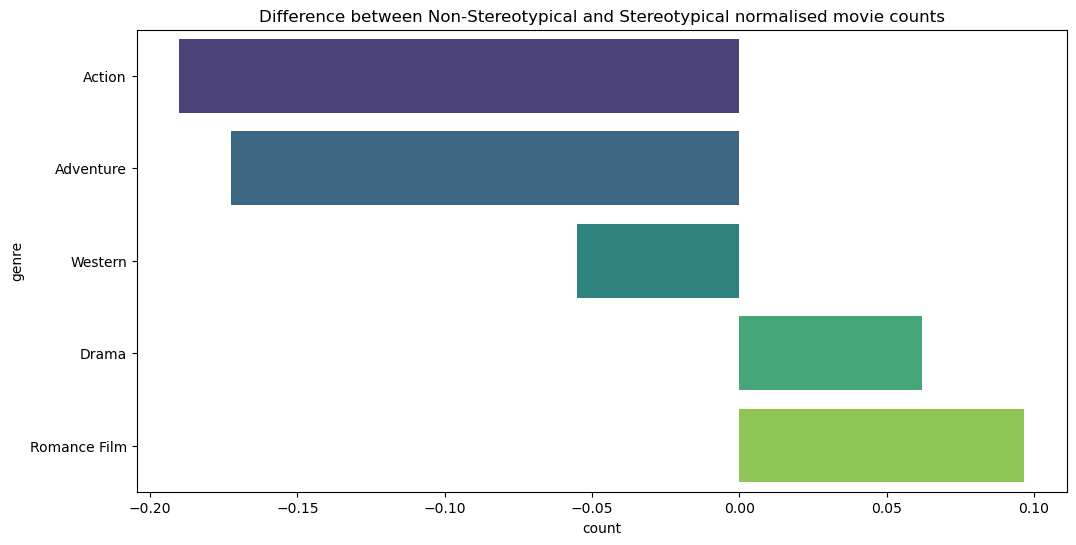

In [59]:
# let's have a look at the difference
# first transform counts into percentages
percentage_diff = \
    not_stereotypical_genre_counts/not_stereotypical_movies.shape[0] - stereotypical_genre_counts/stereotypical_movies.shape[0]
for genre in percentage_diff[percentage_diff.isna()].index:
    if stereotypical_genre_counts[genre] !=0:
        percentage_diff[genre] = -stereotypical_genre_counts[genre]/stereotypical_movies.shape[0]
    elif not_stereotypical_genre_counts[genre] != 0:
        percentage_diff[genre] = not_stereotypical_genre_counts[genre]/not_stereotypical_movies.shape[0]

percentage_diff = percentage_diff.sort_values()
percentage_diff_to_plot = percentage_diff[(percentage_diff.values > 0.05) | (percentage_diff.values < -0.05)]
plt.figure(figsize=(12, 6))
sns.barplot(x=percentage_diff_to_plot, y=percentage_diff_to_plot.index , palette='viridis', orient='h')
plt.title('Difference between Non-Stereotypical and Stereotypical normalised movie counts')
plt.show()

In [60]:
# percentage of stereotypical movie by genre
#total_movies = data.shape[0]
#percentage_stereo = stereotypical_genre_counts/total_movies
#percentage_not_stereo = not_stereotypical_genre_counts/total_movies

#if percentage_stereo.shape[0] > percentage_not_stereo.shape[0]: # there are some genres only in one of the 2 dataset
#    for genre in percentage_stereo.index:
#        if genre not in percentage_not_stereo.index:
#            percentage_not_stereo[genre] = 0

#percentage_stereo = percentage_stereo.sort_index()
#percentage_not_stereo = percentage_not_stereo.sort_index()

#others = 1-percentage_stereo-percentage_not_stereo

#plt.figure(figsize=(12, 6))
#plt.bar(percentage_stereo.index, percentage_stereo.values, label='Stereotypical Movies', alpha=0.6,
#        color='skyblue')
#plt.bar(percentage_not_stereo.index, percentage_not_stereo.values, label='Not Stereotypical Movies', color='pink', alpha=0.6)
#plt.bar(others.index, others.values, bottom=percentage_not_stereo.values+percentage_stereo.values, label='Others')
#plt.title('', fontsize=14)
#plt.xlabel('Genre', fontsize=12)
#plt.ylabel('Proportion of Total Movies', fontsize=12)
#plt.legend()
#plt.xticks(rotation=90)
#plt.show()

In [61]:
#data_merged = pd.merge(movie_data, data, on='IMDB_ID', how='left')
#data_merged

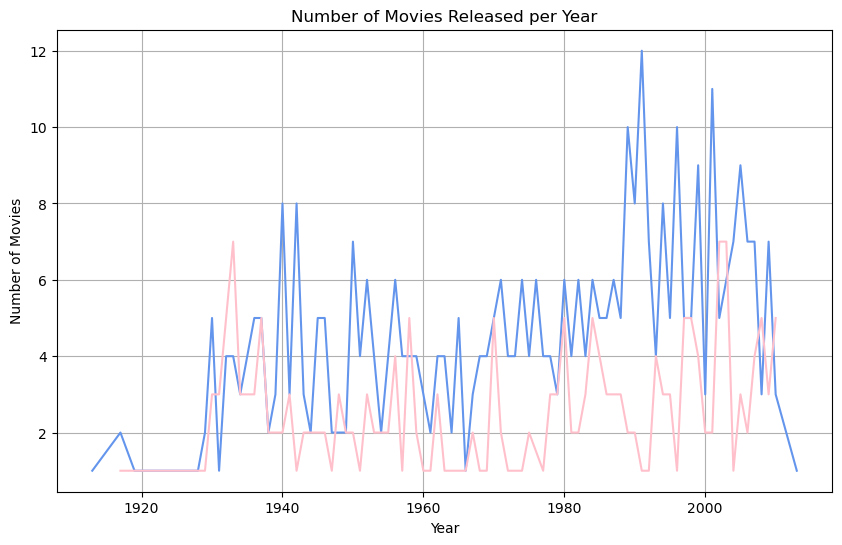

In [62]:
# Group movies by release year
stereo_movie_grouped_by_year = stereotypical_movies.groupby(stereotypical_movies['release_date'])
not_stereo_movie_grouped_by_year = not_stereotypical_movies.groupby(not_stereotypical_movies['release_date'])
#number of movies per year
number_stereo_movies_per_year = stereo_movie_grouped_by_year.size()
number_not_stereo_movies_per_year = not_stereo_movie_grouped_by_year.size()

plt.figure(figsize=(10, 6))
number_stereo_movies_per_year.plot(kind='line', color = 'cornflowerblue')
number_not_stereo_movies_per_year.plot(kind='line', color = 'pink')
plt.title('Number of Movies Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

### Clustering with DBScan -> TO REMOVE ??

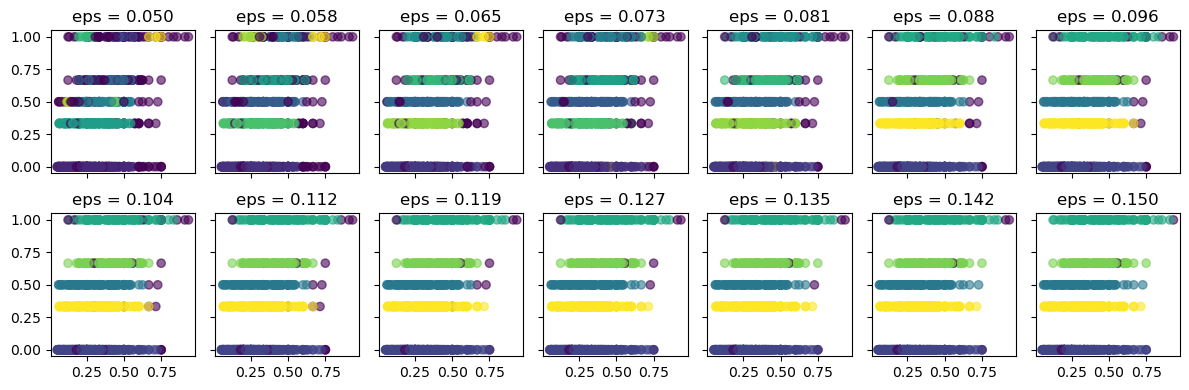

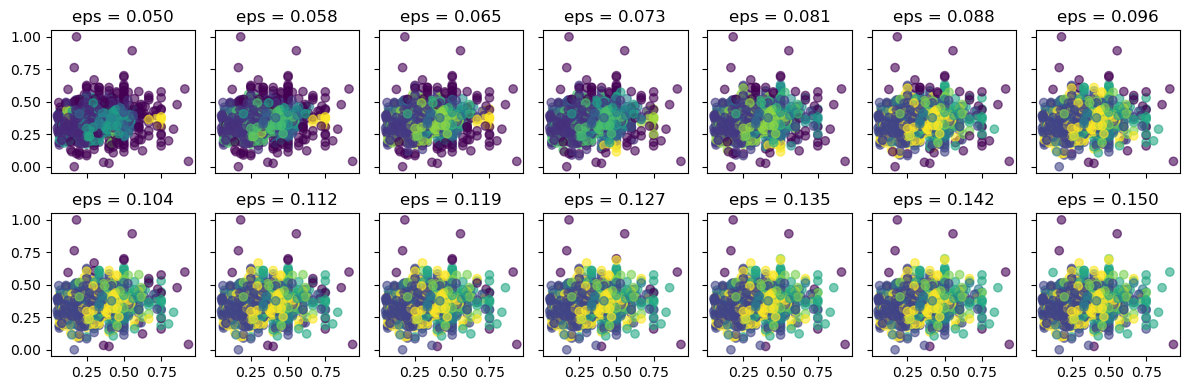

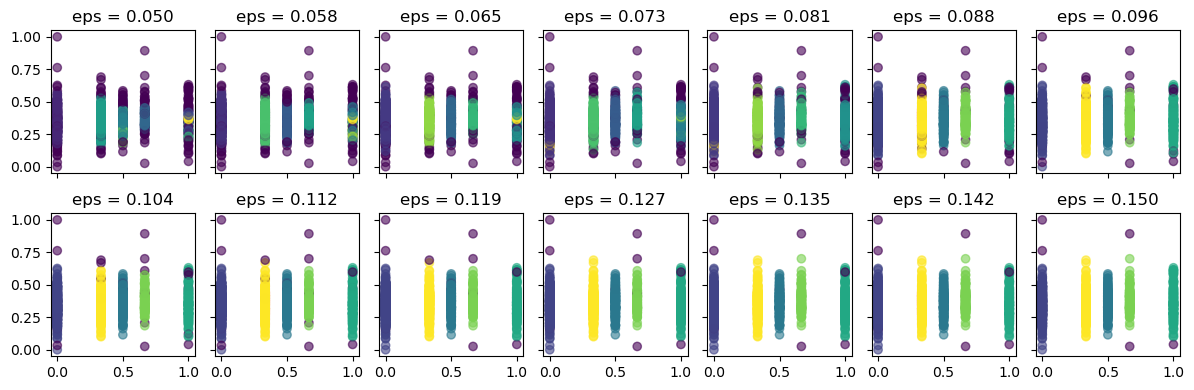

In [64]:
# Create a list of eps
eps_list = np.linspace(0.05, 0.15, 14)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)


for i in range(0, len(eps_list)):
    eps = eps_list[i]

    current_column = i%COLUMNS
    current_row = i//COLUMNS

    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps, min_samples=6).fit_predict(clustering_df)
    ax.scatter(clustering_df['proportion_female'], clustering_df['proportion_female_main_char'], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))

plt.tight_layout()

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]

    current_column = i%COLUMNS
    current_row = i//COLUMNS

    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps, min_samples=6).fit_predict(clustering_df)
    ax.scatter(clustering_df['proportion_female'], clustering_df['difference_mean_ages'], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))

plt.tight_layout()

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)
for i in range(0, len(eps_list)):
    eps = eps_list[i]

    current_column = i%COLUMNS
    current_row = i//COLUMNS

    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps, min_samples=6).fit_predict(clustering_df)
    ax.scatter(clustering_df['proportion_female_main_char'], clustering_df['difference_mean_ages'], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))

plt.tight_layout()

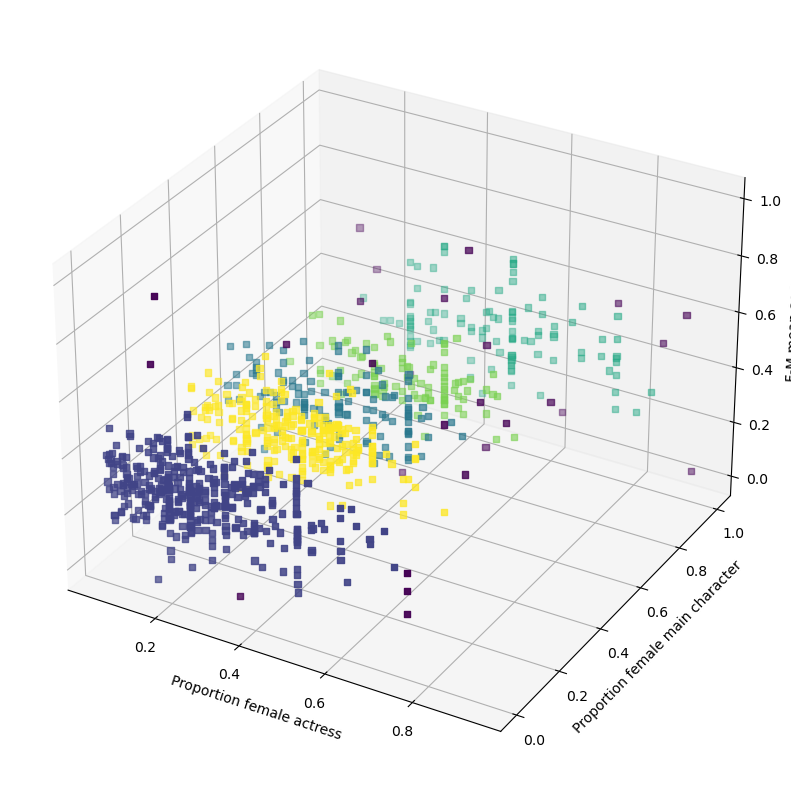

In [65]:
eps = 0.1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
labels = DBSCAN(eps=eps, min_samples=6).fit_predict(clustering_df)
x = np.array(clustering_df['proportion_female'])
y = np.array(clustering_df['proportion_female_main_char'])
z = np.array(clustering_df['difference_mean_ages'])
ax.set_xlabel('Proportion female actress')
ax.set_ylabel('Proportion female main character')
ax.set_zlabel('F-M mean age')

ax.scatter(x,y,z, marker="s", c=labels, s=20)

plt.show()

In [66]:
clustering_df['cluster_index'] = labels
data_concat = pd.concat([clustering_df, stereotype_df['IMDB_ID']], axis=1)
data_concat

,proportion_female,proportion_female_main_char,difference_mean_ages,cluster_index,IMDB_ID
0,0.222222,0.000000,0.432384,0,tt0002851
1,0.454545,0.500000,0.224199,1,tt0006594
2,0.250000,0.000000,0.209964,0,tt0008029
3,0.176471,0.000000,0.313167,0,tt0008133
4,0.500000,1.000000,0.441281,2,tt0008554
...,...,...,...,...,...
1175,0.294118,0.333333,0.490456,4,tt1588334
1176,0.562500,1.000000,0.394764,2,tt1589487
1177,0.526316,0.000000,0.510676,0,tt1695994
1178,0.416667,0.500000,0.376512,1,tt1730687


In [68]:
data_concat.drop(columns='IMDB_ID').groupby('cluster_index').mean()

,proportion_female,proportion_female_main_char,difference_mean_ages
cluster_index,,,
-1,0.550326,0.555556,0.452305
0,0.272829,0.000000,0.347417
1,0.325117,0.500000,0.360394
2,0.459982,1.000000,0.358179
3,0.408723,0.666667,0.377040
4,0.315286,0.333333,0.353570
